In [40]:
from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
import json
import networkx
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous, no_more_discontiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
import pandas
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from functools import partial
import gerrychain.tree_proposals as tp
from gerrychain.constraints.validity import within_percent_of_ideal_population
import matplotlib.pyplot as plt

#NOTE: must have tqdm installed (pip install tqdm in terminal)

In [41]:
#NOTE: An island warning will pop up.
graph = Graph.from_file("/Users/caranix/Documents/MGGG/AK_precincts/alaska_precincts.shp")
print("graph done")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gerrychain/graph/graph.py:196: UserWarning: Found islands (degree-0 nodes). Indices of islands: {352, 394, 372, 351}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


graph done


In [42]:
election = [
    Election("PRES16", {"Democratic": "PRES16D", "Republican": "PRES16R"})]


In [59]:
my_updaters = {
        "cut_edges": cut_edges,
        "population": Tally("POPULATION", alias="population"),
        "PRES16": election
        }

election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = Partition(graph, assignment="HDIST", updaters=my_updaters)

#NOTE: assignment based on House Districts


In [62]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(tp.recom,
                   pop_col="POPULATION",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

In [63]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [60]:
#THIS CHAIN IS NOW WORKING!! (but it isn't based on proposal, but propose_random_flip)

chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[constraints.within_percent_of_ideal_population(initial_partition, .03), no_more_discontiguous, compactness_bound],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

#Super basic Chain

In [66]:
#THIS CHAIN does NOT work (when attempting to run the data= pandas.Dataframe cell I receive: "KeyError: 351"). 

chain = MarkovChain(
    proposal=proposal, #If I change proposal to propose_random_flip then it works
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, .03),
        compactness_bound, no_more_discontiguous
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

#NOTE: The current Alaksa plan does not have population within 2%, I increased it to 3% population deviation.

#NOTE: Apparently, Alaska is not single flip contiguous? Islands might be the issue? 
#Changed to no_more_discontiguous, so it doesn't get any worse. 


In [67]:
#with status bar 
data = pandas.DataFrame(
    sorted(partition["PRES16"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

# This will take about 10 minutes.


KeyError: 351

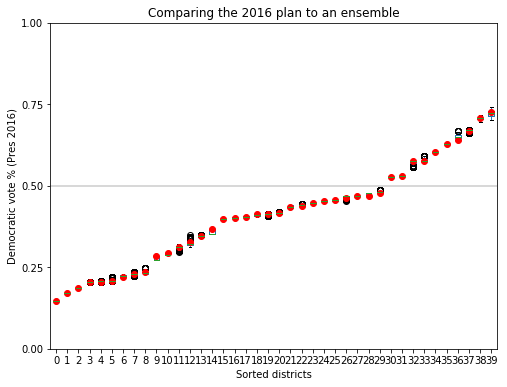

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
data.iloc[0].plot(style="ro", ax=ax)

# Annotate
ax.set_title("Comparing the 2016 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Pres 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

In [81]:
#this was an old error that I was getting before the key error. 

data = pandas.DataFrame(
     sorted(partition["PRES16"].percents("Democratic"))
     for partition in chain.with_progress_bar()
 )


NetworkXPointlessConcept: ('Connectivity is undefined ', 'for the null graph.')

In [ ]:
#data = json.dumps(networkx.readwrite.json_graph.adjacency_data(graph))
#It won't let me save graph due to a Polygon error- not a major issue for me atm 
#with open('/Users/caranix/Documents/alaska_graphAK_DATA.json') as f:
#        data = json.load(f)
#graph = networkx.readwrite.json_graph.adjacency_graph(data)
#this is for when I can fix saving the grpah as a .json
#without status bar- gives same error as above

#data = pandas.DataFrame(
#    sorted(partition["PRES16"].percents("Democratic"))
#    for partition in chain
#)